In [1]:
import numpy as np
import torch
import random
from torch import nn
from utils import train_model
from relaxed_gconv import RelaxedOctahedralConvNet
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# 1. Preprocessing

## 1.1 Load precomputed Oh irreps and create the Fourier transformation matrix

In [3]:
# load precomputed irreps of 48 elements in the Oh group.
irreps = torch.load("data/Oh_irreps.pt")
all_irreps = []
fourier_transform_matrix = [] 
# rearrange the order of irreps
for i in [0, 4, 8, 9, 5, 2, 1, 6, 7, 3]:
    all_irreps.append(irreps[i])
    fourier_transform_matrix.append(irreps[i].reshape(48, -1).transpose(1,0))
fourier_transform_matrix = np.concatenate(fourier_transform_matrix, axis = 0)

oh_classes = ["EE ", "8C3", "6C2", "6C4", "3C2=(C4)2", "ii ", "6S4", "8S6", "3σh", "6σv"]
oh_irreps = ["A1g", "A2g", "Eg", "T1g", "T2g", "A1u", "A2u", "Eu", "T1u", "T2u"]
oh_classes_elements = {oh_classes[i]:[] for i in range(len(oh_classes))}

oh_character_table = np.array([
    [+1,+1,+1,+1,+1,+1,+1,+1,+1,+1],
    [+1,+1,-1,-1,+1,+1,-1,+1,+1,-1],
    [+2,-1,0,0,+2,+2,0,-1,+2,0],
    [+3,0,-1,+1,-1,+3,+1,0,-1,-1],
    [+3,0,+1,-1,-1,+3,-1,0,-1,+1],
    [+1,+1,+1,+1,+1,-1,-1,-1,-1,-1],
    [+1,+1,-1,-1,+1,-1,+1,-1,-1,+1],
    [+2,-1,0,0,+2,-2,0,+1,-2,0],
    [+3,0,-1,+1,-1,-3,-1,0,+1,+1],
    [+3,0,+1,-1,-1,-3,+1,0,+1,-1]])

for element_idx in range(48):
    trace = np.round([np.trace(all_irreps[j][element_idx]).real for j in range(10)])
    class_idx = np.where([np.all(trace == oh_character_table[:,i]) for i in range(10)])[0][0]
    oh_classes_elements[oh_classes[class_idx]].append(element_idx)

# the group elements in each class
oh_classes_elements

{'EE ': [0],
 '8C3': [16, 17, 18, 19, 20, 21, 22, 23],
 '6C2': [27, 28, 32, 34, 40, 46],
 '6C4': [29, 31, 33, 38, 41, 42],
 '3C2=(C4)2': [2, 5, 8],
 'ii ': [30],
 '6S4': [1, 3, 4, 6, 7, 9],
 '8S6': [35, 36, 37, 39, 43, 44, 45, 47],
 '3σh': [24, 25, 26],
 '6σv': [10, 11, 12, 13, 14, 15]}

## 1.2 Visualization Functions

In [4]:
def visulize_relaxed_weights(weights):
    titles = [find_class(oh_classes_elements, i)[1:3] for i in range(48)]
    fig=plt.figure(figsize=(20, 8))
    plt.imshow(weights, cmap = 'Blues')
    plt.xticks(np.arange(0.5,48,1), color='w')
    plt.yticks(np.arange(0.5,3,1), color='w')
    plt.text(-2.8, 0.2, "Layer 1", fontsize=12)
    plt.text(-2.8, 1.2, "Layer 2", fontsize=12)
    plt.text(-2.8, 2.2, "Layer 3", fontsize=12)
    plt.grid(color='black', linestyle='-', linewidth=2)
    plt.title(" "+ " ".join(titles), size = 14.6)
    plt.show()
    
    
def visulize_fourier_components(inp, out, fourier_transform_matrix, signal):
    fourier_compnents = np.round(np.matmul(fourier_transform_matrix, signal), 4)
    fourier_compnents_mag = []
    irreps_dims = [1, 1, 4, 9, 9, 1, 1, 4, 9, 9]
    index = 0
    for i in range(10):
        if irreps_dims[i] > 1:
            fourier_compnents_mag.append(np.linalg.norm(fourier_compnents[index:index+irreps_dims[i]]))
        else:
            fourier_compnents_mag.append(fourier_compnents[index])
        index += irreps_dims[i]

    fig, ax = plt.subplots(figsize=(5.5, 2))
    plt.title(inp + r"$\rightarrow$" + out , size = 12)#+ "(Abs + Log scale)"
    ax.tick_params(bottom=False, left=False)
    xlabel = ["A1g", "A2g", "Eg", "T1g", "T2g", "A1u", "A2u", "Eu", "T1u", "T2u"]
    ax.bar(x = np.arange(10), height = np.abs(fourier_compnents_mag), tick_label = xlabel)
    fig.tight_layout()
    plt.yscale('log') 
    plt.show()
    
# find the group elements that stabilize the given irreps
def find_stabilizer(fourier_coefficients, irrep_indices): 
    irreps_dims = np.array([1, 1, 2, 3, 3, 1, 1, 2, 3, 3])
    irreps_labels = ["A1g", "A2g", "Eg", "T1g", "T2g", "A1u", "A2u", "Eu", "T1u", "T2u"]
    irreps_dims_beg_indices = np.cumsum(irreps_dims**2)
    stabilizers = []
    for irrep_idx, pos_idx in enumerate([0] + list(irreps_dims_beg_indices)[:-1]):
        stab = []
        vec = fourier_coefficients[pos_idx:pos_idx+irreps_dims[irrep_idx]**2].reshape(irreps_dims[irrep_idx], irreps_dims[irrep_idx])
        for elem_idx in range(48):
            if np.all(np.isclose(np.matmul(all_irreps[irrep_idx][elem_idx], vec), vec, rtol=1e-04, atol=1e-04)):
                stab.append(elem_idx)
        stabilizers.append(stab)
    inter_stabilizers = intersection_of_sublists(stabilizers)
    return [(inter_stabilizers[i], find_class(oh_classes_elements, inter_stabilizers[i])) for i in range(len(inter_stabilizers))]

def intersection_of_sublists(nested_list):
    intersection_set = set(nested_list[0])
    for sublist in nested_list[1:]:
        intersection_set.intersection_update(sublist)
    return list(intersection_set)

def find_class(classes_elements, elem_idx):
    for key in classes_elements.keys():
        if elem_idx in classes_elements[key]:
            return key

## 1.3 Load BaTiO3 Data

In [5]:
# Create tensors where the pixels corresponding to atoms are non-zero
mag = 15
direc = "data/batio3/"
with open(direc + 'BaTiO3_cubic.vasp') as f:
    lines = f.readlines()
coordinates_Cubic = np.array([[float(string) for string in lines[8:][i].split()] for i in range(len(lines[8:]))]) * mag

with open(direc + 'BaTiO3_tetra.vasp') as f:
    lines = f.readlines()
coordinates_Tetragonal = np.array([[float(string) for string in lines[8:][i].split()] for i in range(len(lines[8:]))]) * mag

with open(direc + 'BaTiO3_orth.vasp') as f:
    lines = f.readlines()
coordinates_Orthorhombic = np.array([[float(string) for string in lines[8:][i].split()] for i in range(len(lines[8:]))]) * mag

coordinates_Cubic = np.int64(np.round(coordinates_Cubic - coordinates_Cubic.mean(0, keepdims=True))) + 2*mag
coordinates_Tetragonal = np.int64(np.round(coordinates_Tetragonal - coordinates_Tetragonal.mean(0, keepdims=True))) + 2*mag
coordinates_Orthorhombic = np.int64(np.round(coordinates_Orthorhombic - coordinates_Orthorhombic.mean(0, keepdims=True))) + 2*mag

Cubic = torch.zeros((4*mag,4*mag,4*mag))
for i in range(len(coordinates_Cubic)):
    Cubic[coordinates_Cubic[i][0], coordinates_Cubic[i][1], coordinates_Cubic[i][2]]=1
Cubic = Cubic[None, None]

Tetragonal = torch.zeros((4*mag,4*mag,4*mag))
for i in range(len(coordinates_Tetragonal)):
    Tetragonal[coordinates_Tetragonal[i][0], coordinates_Tetragonal[i][1], coordinates_Tetragonal[i][2]]=1
Tetragonal = Tetragonal[None, None]

Orthorhombic = torch.zeros((4*mag,4*mag,4*mag))
for i in range(len(coordinates_Orthorhombic)):
    Orthorhombic[coordinates_Orthorhombic[i][0], coordinates_Orthorhombic[i][1], coordinates_Orthorhombic[i][2]]=1
Orthorhombic = Orthorhombic[None, None]

# 2. Discover Symmetry Breaking Factors

## 2.1 $Pm\bar{3}m \rightarrow Pm\bar{3}m$

In [6]:
in_channels = 1
hidden_dim = 16
kernel_size = 5
reflection = True
num_filter_basis = 1
out_channels = 1

model_cc = RelaxedOctahedralConvNet(in_channels, out_channels, kernel_size, hidden_dim, num_filter_basis, reflection).to(device)

outputs = train_model(model = model_cc, 
                      inp = Cubic.to(device), 
                      tgt =Cubic.to(device), 
                      lr = 1e-3)
relaxed_weights_cc = torch.stack([model_cc.model[i].relaxed_weights.data[0].reshape(-1) for i in range(3)]).cpu().data.numpy()


/global/homes/r/rwang2/.conda/envs/e3nn/lib/python3.9/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch 1 | MSE: 0.00021
Epoch 51 | MSE: 0.00004


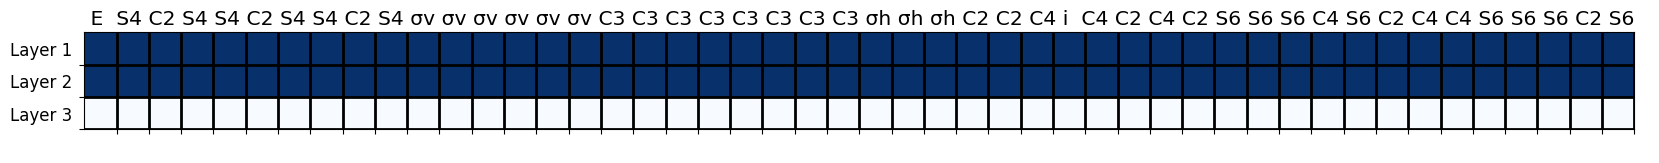

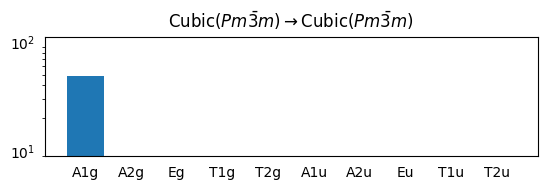

[(0, 'EE '),
 (1, '6S4'),
 (2, '3C2=(C4)2'),
 (3, '6S4'),
 (4, '6S4'),
 (5, '3C2=(C4)2'),
 (6, '6S4'),
 (7, '6S4'),
 (8, '3C2=(C4)2'),
 (9, '6S4'),
 (10, '6σv'),
 (11, '6σv'),
 (12, '6σv'),
 (13, '6σv'),
 (14, '6σv'),
 (15, '6σv'),
 (16, '8C3'),
 (17, '8C3'),
 (18, '8C3'),
 (19, '8C3'),
 (20, '8C3'),
 (21, '8C3'),
 (22, '8C3'),
 (23, '8C3'),
 (24, '3σh'),
 (25, '3σh'),
 (26, '3σh'),
 (27, '6C2'),
 (28, '6C2'),
 (29, '6C4'),
 (30, 'ii '),
 (31, '6C4'),
 (32, '6C2'),
 (33, '6C4'),
 (34, '6C2'),
 (35, '8S6'),
 (36, '8S6'),
 (37, '8S6'),
 (38, '6C4'),
 (39, '8S6'),
 (40, '6C2'),
 (41, '6C4'),
 (42, '6C4'),
 (43, '8S6'),
 (44, '8S6'),
 (45, '8S6'),
 (46, '6C2'),
 (47, '8S6')]

In [7]:
visulize_relaxed_weights(relaxed_weights_cc)
visulize_fourier_components("Cubic"+r"$(Pm\bar{3}m)$", "Cubic"+r"$(Pm\bar{3}m)$", fourier_transform_matrix, relaxed_weights_cc.mean(0))
fourier_compnents = np.round(np.matmul(fourier_transform_matrix, relaxed_weights_cc.mean(0)), 5)
find_stabilizer(fourier_compnents, [0]) # print out the stabilizers. 

## 2.2 $Pm\bar{3}m \rightarrow P4mm$

In [8]:
model_ct = RelaxedOctahedralConvNet(in_channels, out_channels, kernel_size, hidden_dim, num_filter_basis, reflection).to(device)

outputs = train_model(model = model_ct, 
                      inp = Cubic.to(device), 
                      tgt =Tetragonal.to(device), 
                      lr = 1e-3)
relaxed_weights_ct = torch.stack([model_ct.model[i].relaxed_weights.data[0].reshape(-1) for i in range(3)]).cpu().data.numpy()


Epoch 1 | MSE: 0.00021
Epoch 51 | MSE: 0.00014


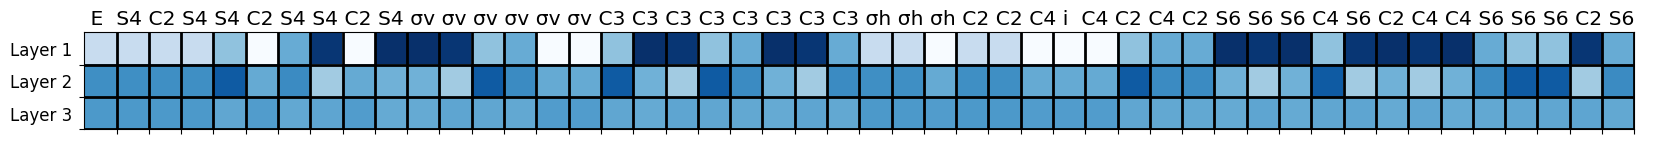

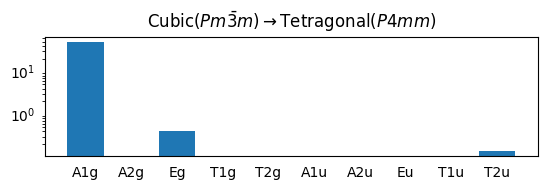

[(0, 'EE '),
 (1, '6S4'),
 (2, '3C2=(C4)2'),
 (3, '6S4'),
 (24, '3σh'),
 (25, '3σh'),
 (27, '6C2'),
 (28, '6C2')]

In [9]:
visulize_relaxed_weights(relaxed_weights_ct)
visulize_fourier_components("Cubic"+r"$(Pm\bar{3}m)$", "Tetragonal"+r"$(P4mm)$", fourier_transform_matrix, relaxed_weights_ct.mean(0))
fourier_compnents = np.round(np.matmul(fourier_transform_matrix, relaxed_weights_ct.mean(0)), 5)
find_stabilizer(fourier_compnents, [0, 2, 9]) # print out the stabilizers. 

## 2.3 $Pm\bar{3}m \rightarrow Amm2$

In [10]:
model_co = RelaxedOctahedralConvNet(in_channels, out_channels, kernel_size, hidden_dim, num_filter_basis, reflection).to(device)

outputs = train_model(model = model_co, 
                      inp = Cubic.to(device), 
                      tgt = Orthorhombic.to(device), 
                      lr = 1e-3)

relaxed_weights_co = torch.stack([model_co.model[i].relaxed_weights.data[0].reshape(-1) for i in range(3)]).cpu().data.numpy()

Epoch 1 | MSE: 0.00022
Epoch 51 | MSE: 0.00020


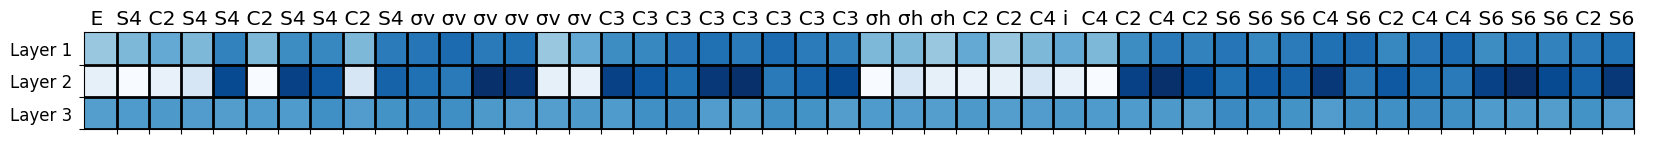

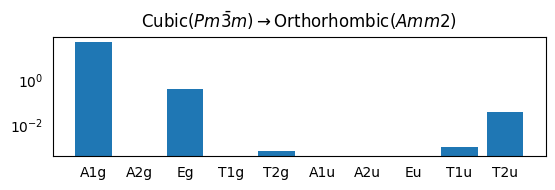

[(0, 'EE '), (26, '3σh'), (28, '6C2'), (14, '6σv')]

In [11]:
visulize_relaxed_weights(relaxed_weights_co)
visulize_fourier_components("Cubic"+r"$(Pm\bar{3}m)$", "Orthorhombic"+r"$(Amm2)$", fourier_transform_matrix, relaxed_weights_co.mean(0))
fourier_compnents = np.round(np.matmul(fourier_transform_matrix, relaxed_weights_co.mean(0)), 5)
find_stabilizer(fourier_compnents, [0, 2, 8, 9]) # print out the stabilizers. 